In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# !pip install pandas fastparquet

# how to actually load and see the first set? 
first_file = '/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet'
df = pd.read_parquet(first_file)

In [ ]:
# how to actually load and see the first set? 
# first_file = '/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet'

# now trying to load it into a dataframe
# try:
#     df = pd.read_parquet(first_file)
#     print(df.head())
# except FileNotFoundError:
#     print(f"Error: File not found {first_file}")
# except Exception as e: 
#     print(f"Error occured when loading file: {e}")

In [ ]:
# how do i even look at 79 features and 9 responders T_T 
# how about i try to look at 10 x 10, at each turn
# just do index... 4 onwards -> 

# df = pd.read_parquet(first_file)
# print(df.shape) # (1944210, 92)
# first_ten = df.head(10).iloc[0:9, 4:14]
# print(first_ten)

# for i in range(4, 85, 10):
#     print(df.iloc[0:9, i:i+10])

In [ ]:
# huhuh okay so chatgpt suggests i can maybe first deal with NaN: 

# df.isnull().sum()
# for i in range(4, 85, 10):
#     print(df.iloc[:, i:i+10].isnull().sum()) 

# looks like there are some at least within this first data set - # (1944210, 92) which are truly all NaN: feature00_04, 
# even based on the NaN count, there are some that look identical: 
    # feature_18, feature_19 
    # feature_32, feature_33
    # feature_45, feature_46
    # feature_50, feature_53
    # feature_52, feature_55
    # feature_56, feature_57
    # feature_73, feature_74...

# check NaN values - dang even seeing this visual matrix shows what is just... empty LOL 
import missingno as msno
msno.matrix(df.iloc[0:200, 0:100])

In [ ]:
# going for df.describe() all at once is too much, need to break it up into 10s.
for i in range(4, 85, 10):
    print(df.iloc[:, i:i+10].describe()) 

In [ ]:
# there are features with count = 0 
# df.all() checks if all "columns" are true - so we turn it into isna() for easier parsing
# print(df.columns[df.isna().all()].tolist()) # ['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_21', 'feature_26', 'feature_27', 'feature_31']

# first I want to see % of na ... chatgpt suggests if 80% drop it, but right now it seems that percentage is less than 17% 
features_only = df.filter(regex='^feature_')
percentage_nan = features_only.isna().sum() / len(features_only)
print(percentage_nan.to_string()) 

In [ ]:
features_1_no_nan = features_only.dropna(axis=1, how='all') 
print(features_1_no_nan.shape) # (1944210, 70) uhhhhh still so many!!! 

In [ ]:
# maybe... let's try correlating with the target..... 

df2 = features_1_no_nan.join(df['responder_6'])
print(df2.head())

In [ ]:
corr = df2.corr()['responder_6']
target_corr = corr.abs().sort_values(ascending=False)
print(target_corr)

In [ ]:
print(target_corr.to_string()) # looks like not that many strong correlations
# responder_6    1.000000
# feature_06     0.087681
# feature_07     0.066128
# feature_05     0.035586
# feature_68     0.027078
# feature_51     0.026465
# feature_19     0.024511
# feature_08     0.022325
# feature_69     0.022006
# feature_56     0.020750
# feature_13     0.019468
# feature_52     0.019101
# feature_54     0.018571
# feature_45     0.018235
# feature_38     0.018021
# feature_18     0.017867
# feature_37     0.017838
# feature_14     0.016198
# feature_59     0.016044
# feature_66     0.015314
# feature_65     0.014706
# feature_60     0.013723
# feature_57     0.013435
# feature_46     0.010571

In [ ]:
msno.matrix(features_1_no_nan.iloc[0:300, 0:100], labels=True, fontsize=8)
# ones that look similar: 32, 33, 58, 73, 74 
# 40, 43 
# 41, 44 
# 45, 46, 65, 66

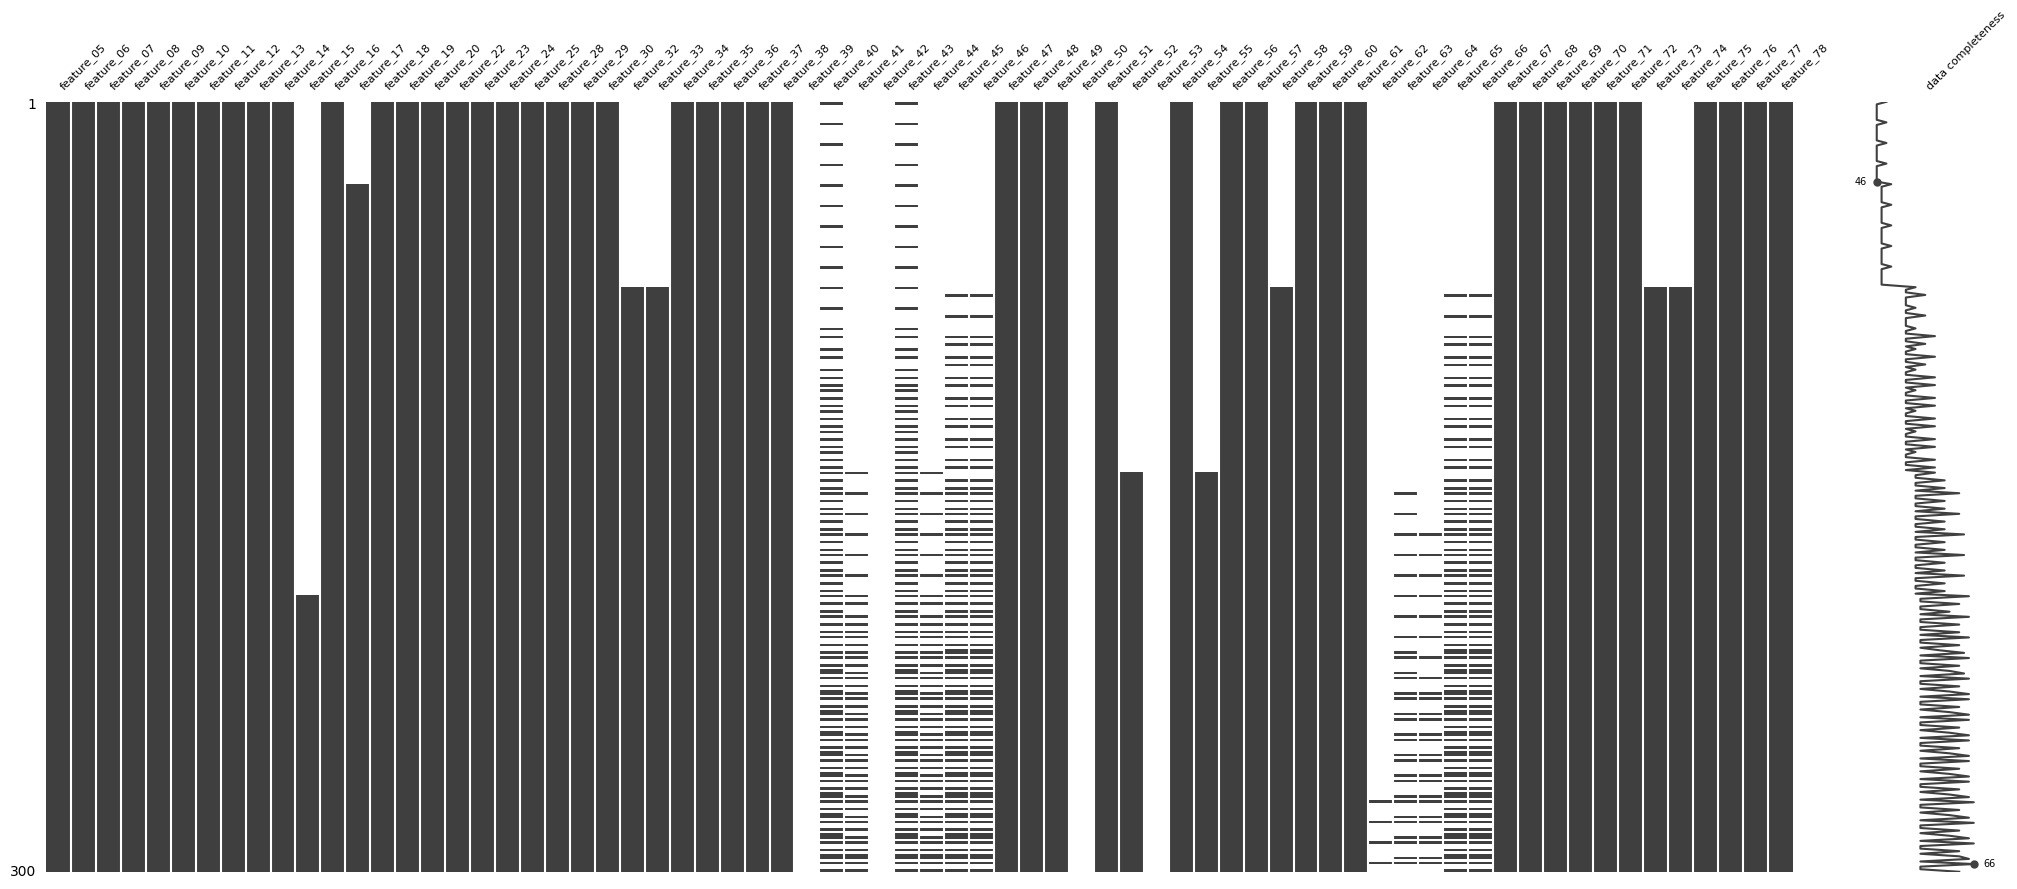
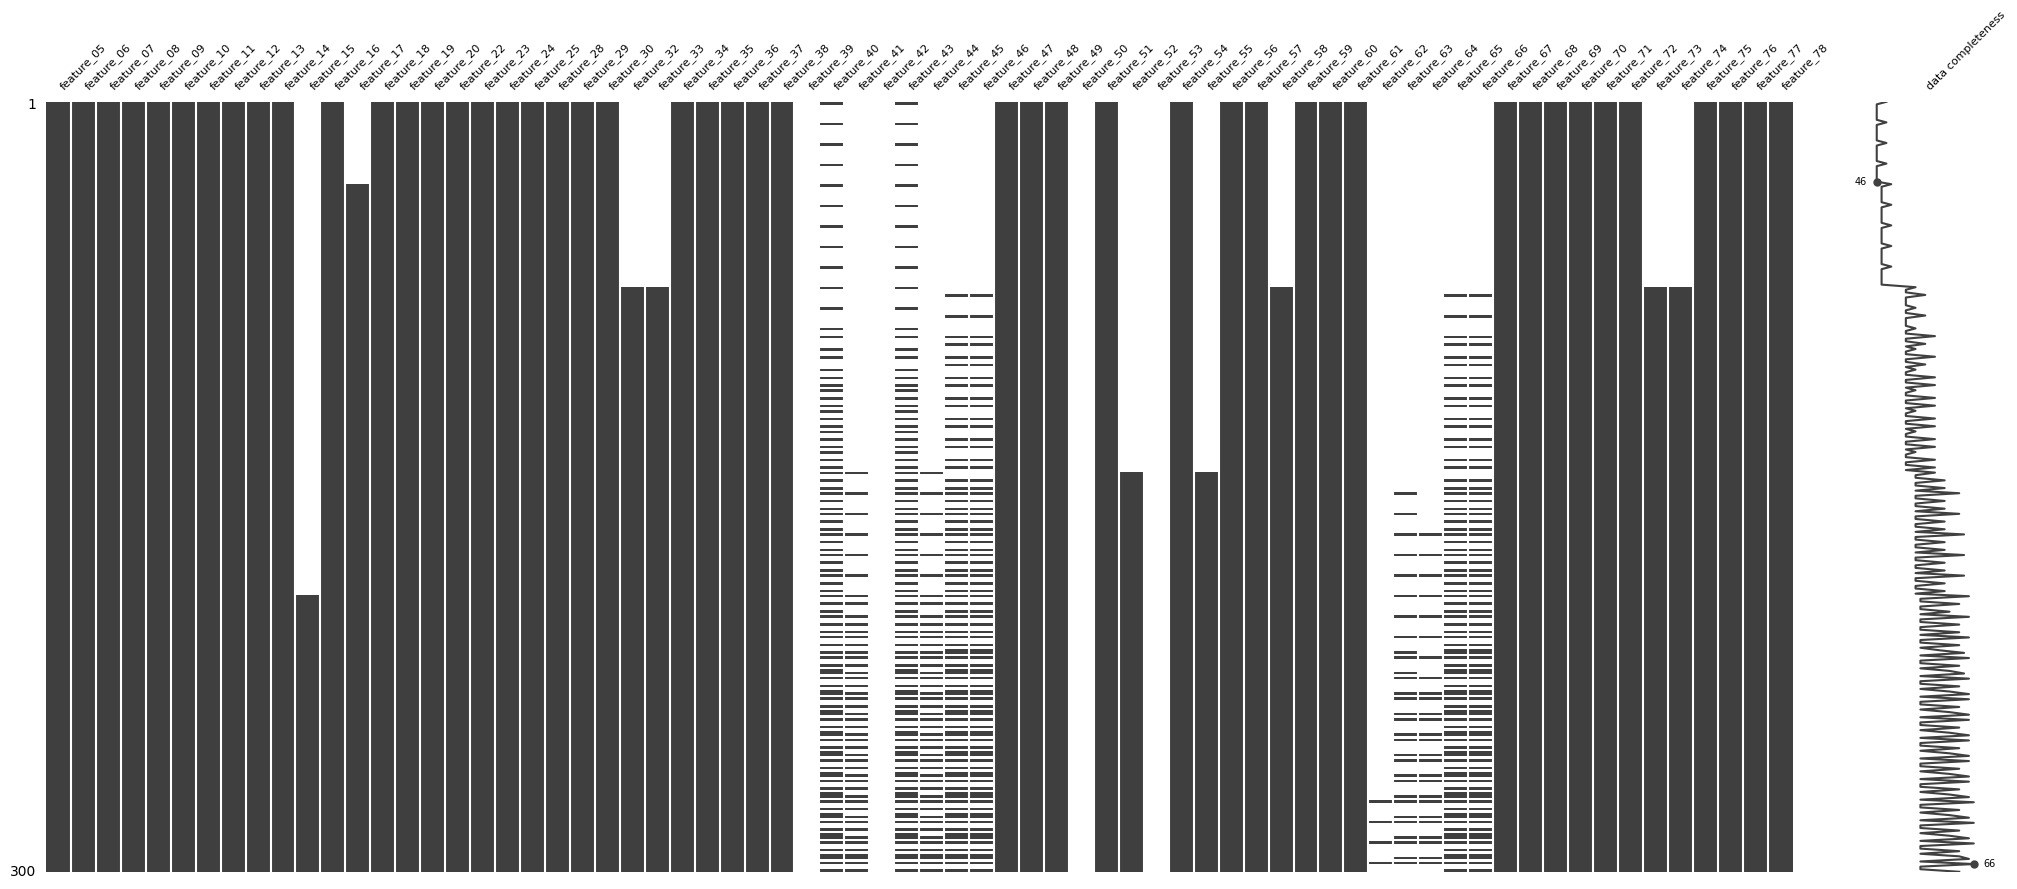

In [ ]:
df1 = features_1_no_nan

columns = [
    ['feature_32', 'feature_33', 'feature_58', 'feature_73', 'feature_74'],
    ['feature_40', 'feature_43'],
    ['feature_41', 'feature_44'],
    ['feature_45', 'feature_46', 'feature_65', 'feature_66']
]

print(df1['feature_40'].corr(df1['feature_43'])) # 0.9492106704314767

In [ ]:
print(df1['feature_41'].corr(df1['feature_44'])) # 0.8432560514296675

In [ ]:
import seaborn as sns

corr = df2.corr()
sns.heatmap(corr) # ooh we get a nice lil graphic.

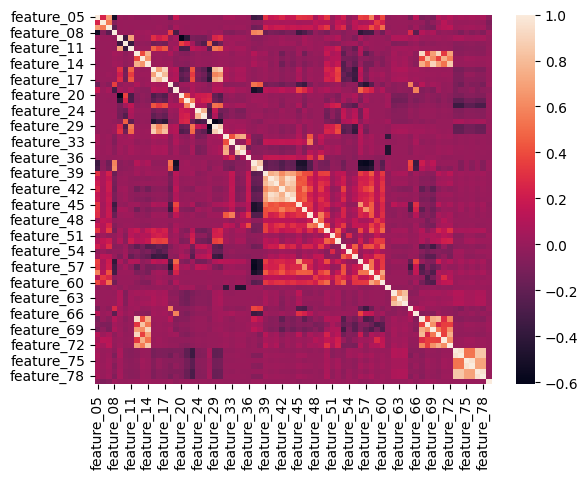

In [ ]:
print(df.head(50)) # we see that there's time_ids in order, and only symbols: 1, 7, 9, 10, 14, 16, 19, 33

# I never looked at the data correctly SOBBBB 

so it's organized as the following: 
- `date_id` , `time_id` , `symbol_id`
    - at least in the first set, it follows ~8 symbols... i can group by these.... x_x 
    - we don't have the actual intervals of date_id
    - _we should be able to handle NEW symbol IDs as well..._ 
- `weight` scores each `symbol_id` and it's repeated - so we probably want to maximize the weights as possible...???

In [ ]:
# ok, now that i'm actually THINKING, let me filter by symbol1

df_1 = df.loc[df['symbol_id'] == 1] # shape: (143481, 92) 143481 = 849 * 169. 
print(df_1.head(30)) 

# date_id 0 -> 169 , timeid from 0 -> 848. although the actual time intervals between time_id values may vary. 

In [ ]:
print(df_1.tail(30))

In [ ]:
df_1_day_1 = df_1[df_1['date_id'] == 1]
print(df_1_day_1.head(10))
print(df_1_day_1.tail(10))

In [ ]:
print(df.tail(28)) # INTERESTING,looking at the tail, seems to be a LOT more towards the last day and time - so we should ideally groupby symbol_id, then see what data exists for which days???
# down here we see: 0, 1, 2, 3, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 30, 33, 34, 38 


Something to also think about, from the video I watched about Quants yesterday - swing trading is looking for correlations _in between symbols_ . So we do want to organize the data by symbol, so also eventually want to see if there's any relationships BETWEEN. 

In [4]:
# groupby symbol_id, then by date_id, then by time_id ? 
df_grouped = df.groupby(['symbol_id'],dropna=False)

count_df = df_grouped.count()
print(count_df.shape) # (20, 91)
#            weight
# symbol_id        
# 0          138387
# 1          143481
# 2           73863
# 3           60279
# 7          140934
# 8          108672
# 9          138387
# 10         102729
# 11          58581
# 12         112068
# 13         110370
# 14          54336
# 15          22074
# 16         141783
# 17          68769
# 19         139236
# 30          20376
# 33         115464
# 34          61128
# 38         133293

(20, 91)


In [14]:
# how many date_ids per symbol?
print(df[['symbol_id', 'date_id']].groupby(['symbol_id'], dropna=False).nunique())

#            date_id
# symbol_id         
# 0              163
# 1              169
# 2               87
# 3               71
# 7              166
# 8              128
# 9              163
# 10             121
# 11              69
# 12             132
# 13             130
# 14              64
# 15              26
# 16             167
# 17              81
# 19             164
# 30              24
# 33             136
# 34              72
# 38             157

           date_id
symbol_id         
0              163
1              169
2               87
3               71
7              166
8              128
9              163
10             121
11              69
12             132
13             130
14              64
15              26
16             167
17              81
19             164
30              24
33             136
34              72
38             157


In [18]:
# let's just look at one slice: 

df_s1_day0 = df.groupby(['symbol_id', 'date_id']).first()
print(df_s1_day0.shape) # (2290, 90) 
print(df_s1_day0.describe())

(2290, 90)
       time_id       weight  feature_00  feature_01  feature_02  feature_03  \
count   2290.0  2290.000000         0.0         0.0         0.0         0.0   
mean       0.0     1.973282         NaN         NaN         NaN         NaN   
std        0.0     0.969408         NaN         NaN         NaN         NaN   
min        0.0     0.440570         NaN         NaN         NaN         NaN   
25%        0.0     1.324020         NaN         NaN         NaN         NaN   
50%        0.0     1.763827         NaN         NaN         NaN         NaN   
75%        0.0     2.393689         NaN         NaN         NaN         NaN   
max        0.0     6.011999         NaN         NaN         NaN         NaN   

       feature_04   feature_05   feature_06   feature_07  ...   feature_78  \
count         0.0  2290.000000  2290.000000  2290.000000  ...  2290.000000   
mean          NaN    -0.144665     0.087261    -0.037401  ...     0.442894   
std           NaN     1.009525     1.126836

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


responder_6    1.000000
responder_3    0.620416
responder_7    0.594057
responder_8    0.514732
responder_4    0.425376
feature_55     0.398590
feature_58     0.396618
feature_52     0.352308
responder_5    0.324894
feature_53     0.286461
feature_50     0.227166
feature_42     0.207311
feature_44     0.145877
feature_39     0.127790
feature_41     0.115027
Name: responder_6, dtype: float64


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


<Axes: >

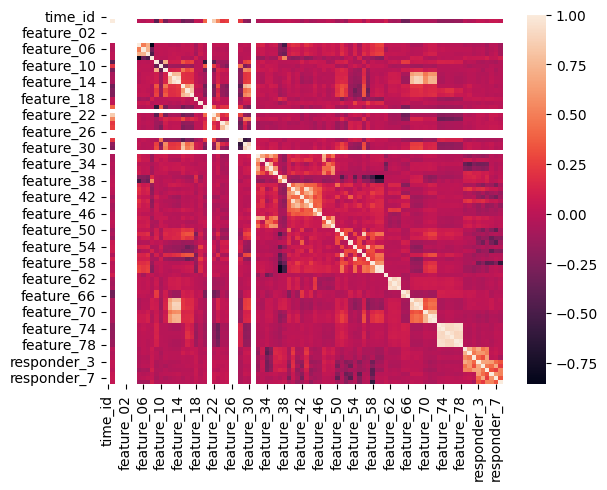

In [21]:
df_1_0_corr = df_s1_day0.corr()
df_1_0_corr_r6 = df_1_0_corr['responder_6']
print(df_1_0_corr_r6.abs().sort_values(ascending=False).head(15))


# responder_6    1.000000
# responder_3    0.620416
# responder_7    0.594057
# responder_8    0.514732
# responder_4    0.425376
# feature_55     0.398590
# feature_58     0.396618
# feature_52     0.352308
# responder_5    0.324894
# feature_53     0.286461
# feature_50     0.227166
# feature_42     0.207311
# feature_44     0.145877
# feature_39     0.127790
# feature_41     0.115027

In [26]:
print(df_1_0_corr.head(30))

df_1_0_corr.filter(regex='^feature_')

# dropna 
# let's see what feature x feature value is the highest? 

            time_id    weight  feature_00  feature_01  feature_02  feature_03  \
time_id         NaN       NaN         NaN         NaN         NaN         NaN   
weight          NaN  1.000000         NaN         NaN         NaN         NaN   
feature_00      NaN       NaN         NaN         NaN         NaN         NaN   
feature_01      NaN       NaN         NaN         NaN         NaN         NaN   
feature_02      NaN       NaN         NaN         NaN         NaN         NaN   
feature_03      NaN       NaN         NaN         NaN         NaN         NaN   
feature_04      NaN       NaN         NaN         NaN         NaN         NaN   
feature_05      NaN -0.002016         NaN         NaN         NaN         NaN   
feature_06      NaN -0.032793         NaN         NaN         NaN         NaN   
feature_07      NaN  0.006013         NaN         NaN         NaN         NaN   
feature_08      NaN  0.010794         NaN         NaN         NaN         NaN   
feature_09      NaN -0.41778

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
